In [1]:
from pyod.models.knn import KNN

In [2]:
# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

NameError: name 'X_train' is not defined

In [2]:
from __future__ import division
from itertools import count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style

In [3]:
style.use('fivethirtyeight')
%matplotlib inline

In [5]:
run = 6
df = pd.read_csv('/Users/meng/Downloads/Wise_Run' + str(run) + '_Trimed.csv')
df = df[['time', 'flapper0']]
df.head()

,time,flapper0
0,0.0,34.025137
1,49.0,34.023675
2,99.0,34.025594
3,149.0,34.027012
4,198.0,34.026033


In [15]:
!mkdir -p dataset

In [16]:
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = loadtxt("dataset/sunspots.txt", float)

# 2. View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.head()

/bin/sh: wget: command not found


OSError: dataset/sunspots.txt not found.

In [11]:
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

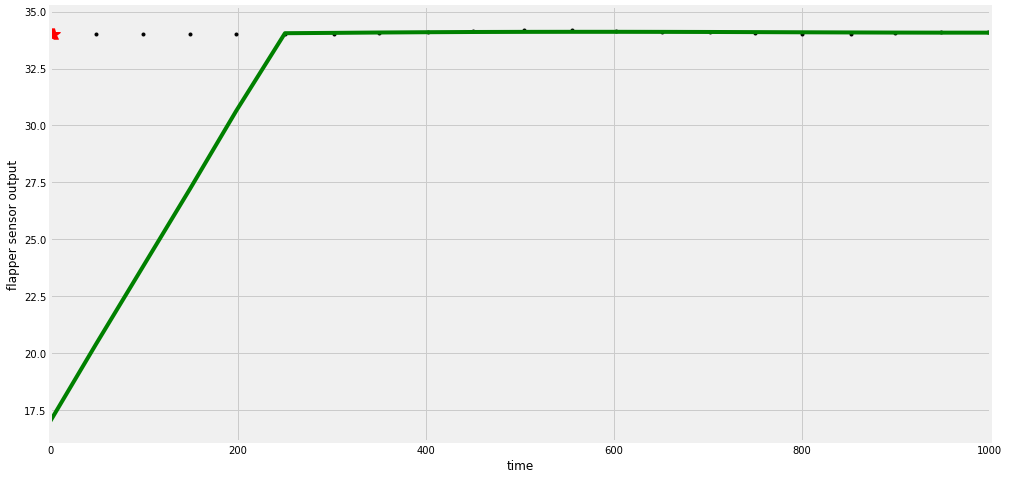

Information about the anomalies model:{'standard_deviation': 0.149, 'anomalies_dict': OrderedDict([(0, 34.02513678491038), (1, 34.02367539568064), (20551, 32.791699609217844), (20552, 32.73827071075352)])}


In [14]:
X = df['time']
Y = df['flapper0']

# plot the results
plot_results(X, Y, window_size=10, text_xlabel="time", sigma_value=3,
             text_ylabel="flapper sensor output")
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))